### *Начало пути. Импорт библиотек и данных.*

In [1]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2, RFE, VarianceThreshold, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier

C:\Users\knigo\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
in_df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender = pd.read_csv('gender_submission.csv')

***
*Просмотр данных.*
***

In [3]:
in_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
in_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

***
*Понемногу будем убирать ненужные. Кабину (каюту) очевидно можно убрать, ближе к концу будет строчка дропа. Возраст заменим по нормальному распределению, а порт отправления пассажира оценим исходя из величины оплаты.*
***

In [6]:
in_df.shape, test.shape

((891, 12), (418, 11))

In [7]:
df = pd.concat((in_df, test), sort = True, ignore_index=True)
df.loc[df.Embarked.isna()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [8]:
df.shape

(1309, 12)

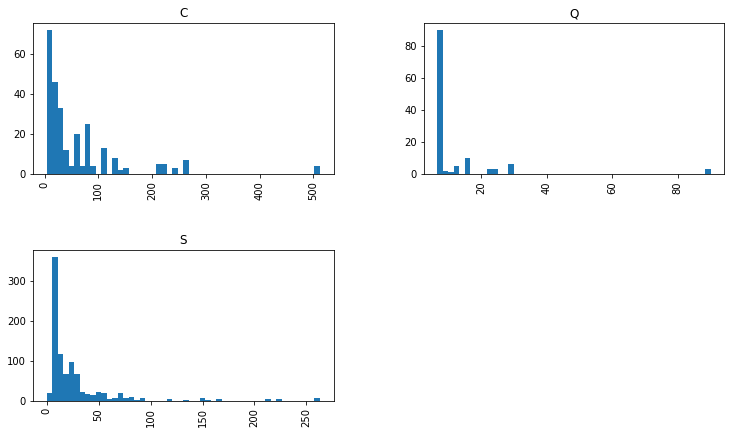

In [9]:
hist = df.hist(column = 'Fare', by = 'Embarked', grid=True, figsize = (12, 7), bins = 50)

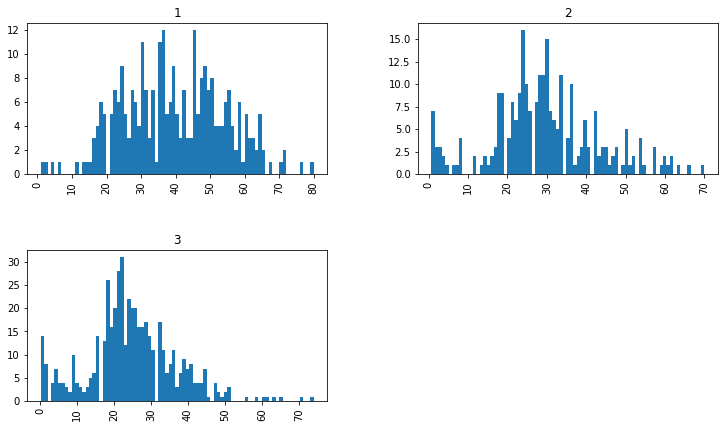

In [10]:
df.loc[df.Embarked.isna(), 'Embarked'] = 'S'
n_bins = int(df.Age.max()-df.Age.min())
hist = df.hist(column = 'Age', by = 'Pclass', grid=True, figsize = (12, 7), bins = n_bins)

***
*Видно, что 80 отдали либо в S, либо в C. Предположим, что это S (это также подтвердится, если прогуглить имя).  
У единственного пассажира без оплаты в графе Fare ставим среднее значение по всем, у кого такой же класс и порт отправления.  
Теперь к возрасту. Заполним пустые по нормальному распределению (как уже было сказано), которое кажется тут достаточно правдоподобным. Затем выполним агрегирование.*
***

In [11]:
df.isna().sum()

Age             263
Cabin          1014
Embarked          0
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [12]:
df.loc[df.Fare.isna()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [13]:
df.loc[df.Fare.isna(), 'Fare'] = df.where((df.Pclass == 3)&(df.Embarked == 'S')).dropna().Age.mean()

In [14]:
age1 = round(df.where(df.Pclass == 1).dropna().Age.mean())
age1_std = round(np.std(df.where(df.Pclass == 1).dropna().Age))
age2 = round(df.where(df.Pclass == 2).dropna().Age.mean())
age2_std = round(np.std(df.where(df.Pclass == 2).dropna().Age))
age3 = round(df.where(df.Pclass == 3).dropna().Age.mean())
age3_std = round(np.std(df.where(df.Pclass == 3).dropna().Age))

for i in range(df.shape[0]):
    if df.Age.isna()[i] == True:
        if df.Pclass[i] == 1:
            df.Age[i] = abs(np.random.normal(age1, age1_std, 1).round().astype(int)[0])
        elif df.Pclass[i] == 2:
            df.Age[i] = abs(np.random.normal(age2, age2_std, 1).round().astype(int)[0])
        else:
            df.Age[i] = abs(np.random.normal(age3, age3_std, 1).round().astype(int)[0])

C:\Users\knigo\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\knigo\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\knigo\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


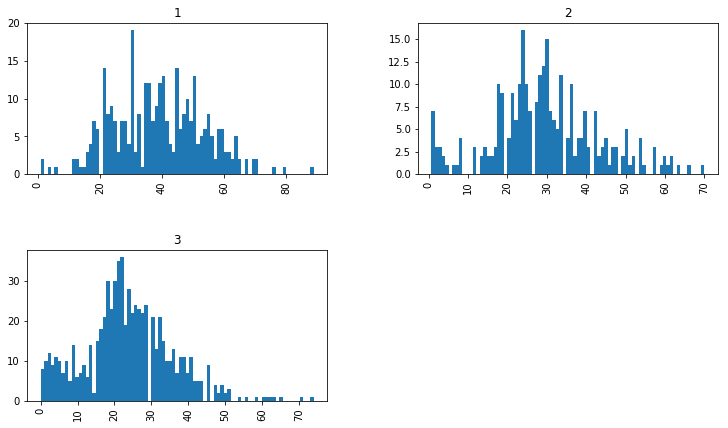

In [15]:
hist = df.hist(column = 'Age', by = 'Pclass', grid=True, figsize = (12, 7), bins = n_bins)

In [16]:
df['Sector'] = df.Cabin.apply(lambda s: s[0] if pd.notnull(s) else 'M')
print('Unique sectors are', df.Sector.unique())
df.loc[df.Sector == 'T']

Unique sectors are ['M' 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Sector
339,45.0,T,S,35.5,"Blackwell, Mr. Stephen Weart",0,340,1,male,0,0.0,113784,T


In [17]:
df.loc[df.Sector == 'A']

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Sector
23,28.0,A6,S,35.5000,"Sloper, Mr. William Thompson",0,24,1,male,0,1.0,113788,A
96,71.0,A5,C,34.6542,"Goldschmidt, Mr. George B",0,97,1,male,0,0.0,PC 17754,A
174,56.0,A7,C,30.6958,"Smith, Mr. James Clinch",0,175,1,male,0,0.0,17764,A
185,40.0,A32,S,50.0000,"Rood, Mr. Hugh Roscoe",0,186,1,male,0,0.0,113767,A
209,40.0,A31,C,31.0000,"Blank, Mr. Henry",0,210,1,male,0,1.0,112277,A
284,55.0,A19,S,26.0000,"Smith, Mr. Richard William",0,285,1,male,0,0.0,113056,A
445,4.0,A34,S,81.8583,"Dodge, Master. Washington",2,446,1,male,0,1.0,33638,A
475,38.0,A14,S,52.0000,"Clifford, Mr. George Quincy",0,476,1,male,0,0.0,110465,A
556,48.0,A16,C,39.6000,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",0,557,1,female,1,1.0,11755,A
583,36.0,A10,C,40.1250,"Ross, Mr. John Hugo",0,584,1,male,0,0.0,13049,A


In [18]:
# Меняю сектор T на A, так как первый класс наиболее соотствествует каютам из этого сектора, плюс по размеру платы похоже.
df.Sector.replace({'T': 'A'}, inplace = True)

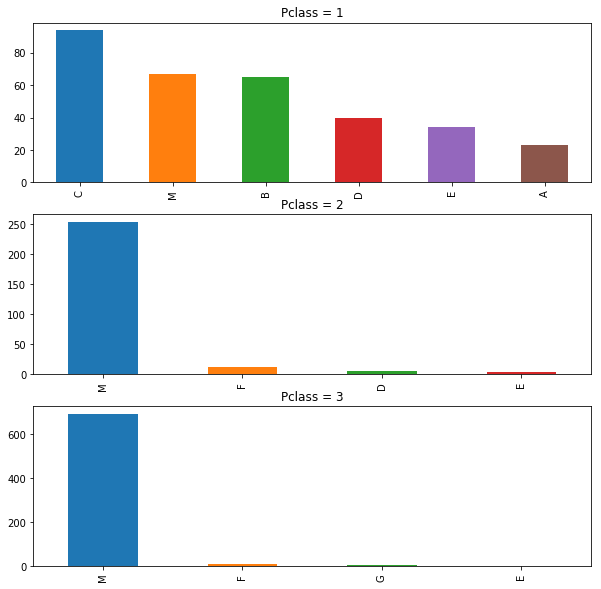

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (10, 10))
df.loc[df.Pclass == 1].Sector.value_counts().plot(kind = 'bar', ax = axes[0], title = 'Pclass = 1')
df.loc[df.Pclass == 2].Sector.value_counts().plot(kind = 'bar', ax = axes[1], title = 'Pclass = 2')
df.loc[df.Pclass == 3].Sector.value_counts().plot(kind = 'bar', ax = axes[2], title = 'Pclass = 3')
plt.show()

***
*Очевидно, что имеются ощутимые проблемы с определением кают у 2го и 3го класса, однако важно понимание, что никто кроме 1го класса не обитал в каютах их секторов A, B и C. Также, 1ый класс не жил в каютах сектора G. Соответственно, группирую.*
***

In [20]:
df['Sector'] = df.Sector.replace(['A', 'B', 'C'], 'ABC')
df['Sector'] = df.Sector.replace(['D', 'E'], 'DE')
df['Sector'] = df.Sector.replace(['F', 'G'], 'FG')

In [21]:
df.Sector.unique()

array(['M', 'ABC', 'DE', 'FG'], dtype=object)

In [22]:
df.drop(['Cabin'], inplace = True, axis = 1)
df.loc[(df.SibSp == 0)&(df.Parch == 0), 'Alone'] = 1
df.loc[(df.SibSp != 0)|(df.Parch != 0), 'Alone'] = 0
df['Family'] = df.SibSp + df.Parch

In [23]:
# Пустых колонок нет.
df.drop(columns = 'Survived').isna().sum() == 0

Age            True
Embarked       True
Fare           True
Name           True
Parch          True
PassengerId    True
Pclass         True
Sex            True
SibSp          True
Ticket         True
Sector         True
Alone          True
Family         True
dtype: bool

***
*Конечный взгляд на полученный датасет. Данные по SibSp и Parch переделаны в Alone и Family.*
***

In [24]:
df.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Sector,Alone,Family
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,M,0.0,1
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,ABC,0.0,1
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,M,1.0,0
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,ABC,0.0,1
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,M,1.0,0


In [25]:
df.shape

(1309, 14)

In [26]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


***
*Разделяем датасеты обратно.*
***

In [27]:
df.head(10)

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Sector,Alone,Family
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,M,0.0,1
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,ABC,0.0,1
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,M,1.0,0
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,ABC,0.0,1
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,M,1.0,0
5,9.0,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877,M,1.0,0
6,54.0,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463,DE,1.0,0
7,2.0,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909,M,0.0,4
8,27.0,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742,M,0.0,2
9,14.0,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736,M,0.0,1


In [28]:
df_train = df[:in_df.shape[0]]
df_test = df[-test.shape[0]:]

df_train_corr = df_train.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

df_test_corr = df_test.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)

In [29]:
df_test.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Sector,Alone,Family
891,34.5,Q,7.8292,"Kelly, Mr. James",0,892,3,male,0,NaN,330911,M,1.0,0
892,47.0,S,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,female,1,NaN,363272,M,0.0,1
893,62.0,Q,9.6875,"Myles, Mr. Thomas Francis",0,894,2,male,0,NaN,240276,M,1.0,0
894,27.0,S,8.6625,"Wirz, Mr. Albert",0,895,3,male,0,NaN,315154,M,1.0,0
895,22.0,S,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,female,1,NaN,3101298,M,0.0,2


In [30]:
df_train.tail()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Sector,Alone,Family
886,27.0,S,13.00,"Montvila, Rev. Juozas",0,887,2,male,0,0.0,211536,M,1.0,0
887,19.0,S,30.00,"Graham, Miss. Margaret Edith",0,888,1,female,0,1.0,112053,ABC,1.0,0
888,23.0,S,23.45,"Johnston, Miss. Catherine Helen ""Carrie""",2,889,3,female,1,0.0,W./C. 6607,M,0.0,3
889,26.0,C,30.00,"Behr, Mr. Karl Howell",0,890,1,male,0,1.0,111369,ABC,1.0,0
890,32.0,Q,7.75,"Dooley, Mr. Patrick",0,891,3,male,0,0.0,370376,M,1.0,0


In [31]:
corr = df_train_corr_nd['Correlation Coefficient'] > 0.1
df_train_corr_nd[corr].head(10)

,Feature 1,Feature 2,Correlation Coefficient
8,SibSp,Family,0.890712
10,Parch,Family,0.783111
12,Alone,Family,0.690922
14,Alone,SibSp,0.584471
16,Alone,Parch,0.583398
18,Fare,Pclass,0.549500
20,SibSp,Parch,0.414838
22,Pclass,Age,0.397362
24,Pclass,Survived,0.338481
26,Fare,Alone,0.271832


In [32]:
corr = df_test_corr_nd['Correlation Coefficient'] > 0.1
df_test_corr_nd[corr].head(10)

,Feature 1,Feature 2,Correlation Coefficient
8,Parch,Family,0.827242
10,SibSp,Family,0.788610
12,Family,Alone,0.685316
14,SibSp,Alone,0.618483
16,Pclass,Fare,0.577120
18,Age,Pclass,0.515815
20,Parch,Alone,0.495618
22,Fare,Age,0.336450
24,Parch,SibSp,0.306895
26,Fare,Alone,0.282753


***
*Теперь агрегирую возраст и плату.*
***

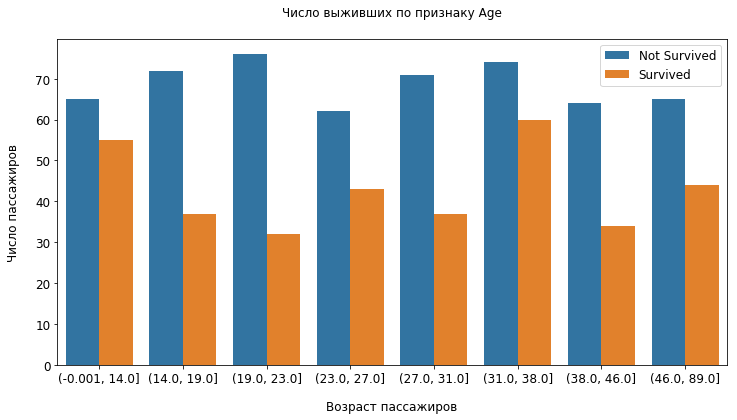

In [33]:
df['Age'] = pd.qcut(df['Age'], 8)
fig, axs = plt.subplots(figsize=(12, 6))
sns.countplot(x='Age', hue='Survived', data=df)
l_s = 12
plt.xlabel('Возраст пассажиров', size=l_s, labelpad=15)
plt.ylabel('Число пассажиров', size=l_s, labelpad=15)
plt.tick_params(axis='x', labelsize=l_s)
plt.tick_params(axis='y', labelsize=l_s)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': l_s})
plt.title('Число выживших по признаку {}'.format('Age'), size=l_s, y=1.05)

plt.show()

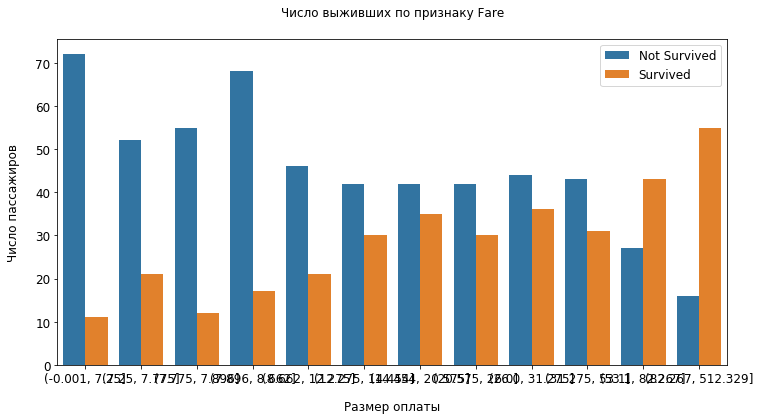

In [34]:
df['Fare'] = pd.qcut(df['Fare'], 12)
fig, axs = plt.subplots(figsize=(12, 6))
sns.countplot(x='Fare', hue='Survived', data=df)
l_s = 12
plt.xlabel('Размер оплаты', size=l_s, labelpad=15)
plt.ylabel('Число пассажиров', size=l_s, labelpad=15)
plt.tick_params(axis='x', labelsize=l_s)
plt.tick_params(axis='y', labelsize=l_s)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': l_s})
plt.title('Число выживших по признаку {}'.format('Fare'), size=l_s, y=1.05)

plt.show()

In [35]:
df.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Sector,Alone,Family
0,"(19.0, 23.0]",S,"(-0.001, 7.25]","Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,M,0.0,1
1,"(31.0, 38.0]",C,"(53.1, 82.267]","Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,ABC,0.0,1
2,"(23.0, 27.0]",S,"(7.896, 8.662]","Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,M,1.0,0
3,"(31.0, 38.0]",S,"(31.275, 53.1]","Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,ABC,0.0,1
4,"(31.0, 38.0]",S,"(7.896, 8.662]","Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,M,1.0,0


In [36]:
df_train = df[:in_df.shape[0]]
df_test = df[-test.shape[0]:]

dfs = [df_train, df_test]
non_numeric_features = ['Embarked', 'Sex', 'Sector', 'Age', 'Fare']

for df_ in dfs:
    for feature in non_numeric_features:        
        df_[feature] = LabelEncoder().fit_transform(df_[feature])

C:\Users\knigo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [37]:
type(dfs)

list

In [38]:
cat_features = ['Pclass', 'Sex', 'Sector', 'Embarked', 'Family']
encoded_features = []

for df_ in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df_[feature].values.reshape(-1, 1)).toarray()
        n = df_[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df_.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:len(cat_features)]], axis=1)
df_test = pd.concat([df_test, *encoded_features[len(cat_features):]], axis=1)

In [39]:
df_all = pd.concat([df_train, df_test], sort=True).reset_index(drop=True)
drops = ['Embarked', 'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'Ticket', 'SibSp', 'Family', 'Survived']
df_all.drop(columns=drops, inplace=True)
df_all.head()

,Age,Alone,Embarked_1,Embarked_2,Embarked_3,Family_1,Family_2,Family_3,Family_4,Family_5,...,Pclass_1,Pclass_2,Pclass_3,Sector,Sector_1,Sector_2,Sector_3,Sector_4,Sex_1,Sex_2
0,2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3,0.0,0.0,0.0,1.0,0.0,1.0
1,5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0,1.0,0.0,0.0,0.0,1.0,0.0
2,3,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3,0.0,0.0,0.0,1.0,1.0,0.0
3,5,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0,1.0,0.0,0.0,0.0,1.0,0.0
4,5,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3,0.0,0.0,0.0,1.0,0.0,1.0


In [40]:
df_test

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,...,Embarked_3,Family_1,Family_2,Family_3,Family_4,Family_5,Family_6,Family_7,Family_8,Family_9
891,5,1,2,"Kelly, Mr. James",0,892,3,1,0,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
892,7,2,0,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,0,1,NaN,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
893,7,1,4,"Myles, Mr. Thomas Francis",0,894,2,1,0,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
894,3,2,3,"Wirz, Mr. Albert",0,895,3,1,0,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
895,2,2,5,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,0,1,NaN,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
896,0,2,4,"Svensson, Mr. Johan Cervin",0,897,3,1,0,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
897,4,1,1,"Connolly, Miss. Kate",0,898,3,0,0,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
898,3,2,8,"Caldwell, Mr. Albert Francis",1,899,2,1,1,NaN,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
899,1,0,0,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",0,900,3,0,0,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
900,2,2,7,"Davies, Mr. John Samuel",0,901,3,1,2,NaN,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
X_train = StandardScaler().fit_transform(df_train.drop(columns=drops))
y_train = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_test.drop(columns=drops))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 25)
y_train shape: (891,)
X_test shape: (418, 25)


In [42]:
importances['Mean_Importance'] = importances.mean(axis=1)
importances.sort_values(by='Mean_Importance', inplace=True, ascending=False)

plt.figure(figsize=(15, 20))
sns.barplot(x='Mean_Importance', y=importances.index, data=importances)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Random Forest Classifier Mean Feature Importance Between Folds', size=15)

plt.show()

NameError: name 'importances' is not defined

In [ ]:
rfc = RandomForestClassifier(random_state=1)
knn = KNeighborsClassifier()
lgr = LogisticRegression()
xgb = XGBClassifier()
gbc = GradientBoostingClassifier()
svc = SVC(probability=True)
gnb = GaussianNB()

models = [rfc, knn, lgr, xgb, gbc, svc, gnb]         
scores = []

for mod in models:
    mod.fit(X_train, y_train)
    acc = cross_val_score(mod, X_train, y_train, scoring = "accuracy", cv = 8)
    scores.append(acc.mean())

In [ ]:
results = pd.DataFrame({
    'Model': ['Random Forest', 'K Nearest Neighbour', 'Logistic Regression', 'XGBoost', 'Gradient Boosting', 'SVC', 'Gaussian Naive Bayes'],
    'Score': scores})

result_df = results.sort_values(by='Score', ascending=False).reset_index(drop=True)
result_df.head()

In [ ]:
corr = df_all.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(14, 8))
plt.title('Корреляция признаков', fontsize=16)
sns.heatmap(corr, mask=mask, annot=False,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})
plt.show()

In [ ]:
choose_alg = VotingClassifier(estimators = [('Random Forest', rfc), 
                                           ('Logistic Regression', lgr),
                                           ('XGBoost', xgb),
                                           ('Gradient Boosting', gbc),
                                           ('SVC', svc),
                                           ('K Nearest Neighbour', knn)], voting = 'soft')

choose_alg_cv = cross_validate(choose_alg, X_train, y_train, cv = 8)
choose_alg.fit(X_train, y_train)

print("Soft voting on test set score mean: {:.2f}". format(choose_alg_cv['test_score'].mean()*100))

In [ ]:
passId = test['PassengerId']
predictions = choose_alg.predict(X_test)

submission = pd.concat([pd.DataFrame(passId), pd.DataFrame(predictions).astype('int')], axis = 'columns')

submission.columns = ["PassengerId", "Survived"]
submission.to_csv('titanic_submission_1.csv', header = True, index = False)